# Model comparison using Bayesian evidence
In this notebook, we compare models for a generated data trajectory.
We are given a trajectory of a SEIR model and fit this data with both a SEIR as well as a simpler SIR model.
We compare these models by computing their Bayesian evidence.

Pyross supports evidence computation in two ways.
We can either estimate the evidence exactly (but with random error) using nested sampling or by integrating the Laplace approximation of the model at the MAP estimate.
The second method tends to be faster, but it performs very poorly here.
Part of the problem is the finite difference computation of the Hessian of the log-likelihood, which turns out to be very dependent on the step size `eps`.
Therefore, these results cannot be trusted here.
This is something that should be checked before relying on the Laplace approximation.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory from the SEIR model
We generate a test trajectory on a population with two ages groups.

In [3]:
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([1, 1])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

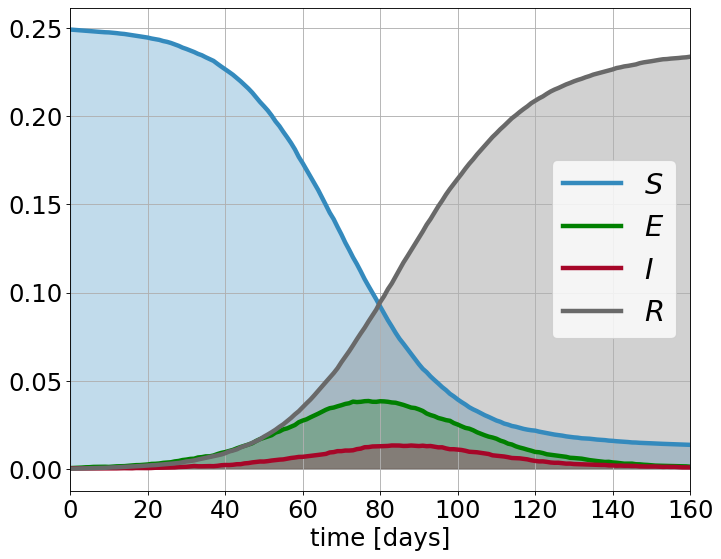

In [4]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Compute the model evidence for the SEIR model
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory.

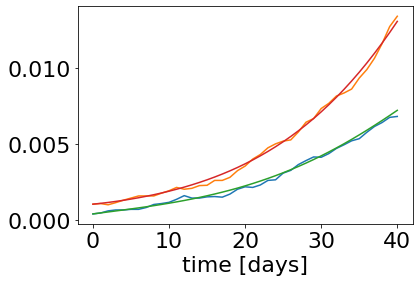

In [5]:
# load the data and rescale to intensive variables 
N_start = 20  
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x) 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.plot(obs[:, -2:])
plt.plot(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.xlabel("time [days]")
plt.show()


In [6]:
# Make parameter guesses (and define bounds for the MAP estimate later)
eps = 1e-3

param_priors = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 5]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 5]
    },
    'gE':{
        'mean': 0.1, 
        'std': 0.05, 
        'bounds': [eps, 5]
    }
}

fsa_g = 0.8 # not inferred 

E0_g = x0[M:2*M]
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.1/N, 500/N], M).reshape(M, 2)

Ia0_g = x0[2*M:3*M]
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.1/N, 500/N], M).reshape(M, 2)

init_fltr = np.repeat([False, True, True, False], M)
init_priors = {
    'independent': {
        'fltr': init_fltr,
        'mean': [*E0_g, *Ia0_g],
        'std': [*E_std, *Ia_std],
        'bounds': [*bounds_for_E, *bounds_for_Ia]
    }
}

start_time = time.time()
sampler = estimator.nested_sampling_latent_inference(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,  
                                                    tangent=True, verbose=True, nlive=150, nprocesses=2) 
end_time = time.time()
print(end_time - start_time)

result, samples = estimator.nested_sampling_latent_inference_process_result(sampler, obs, fltr, param_priors, init_priors)

2164it [05:59,  6.02it/s, +150 | bound: 33 | nc: 1 | ncall: 12550 | eff(%): 18.438 | loglstar:   -inf < 1234.781 <    inf | logz: 1222.243 +/-  0.243 | dlogz:  0.001 >  0.159]


363.81407618522644


In [7]:
print("Model log-evidence for SEIR (computed by nested sampling): ", result.logz[-1])

Model log-evidence for SEIR (computed by nested sampling):  1222.242816642147


In [8]:
ftol = 1e-11 # the relative tol in (-logp)  

start_time = time.time()
params = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                           tangent=True, global_max_iter=250, local_max_iter=1000, global_atol=1.0, 
                                           cma_population=50, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 8 (seed=875278010, Mon Jul 20 18:29:20 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -1.152467720640662e+03 1.0e+00 1.03e+00  2e-04  1e-01 0:01.2
    2    100 -1.201274394075872e+03 1.4e+00 9.71e-01  2e-04  9e-02 0:03.0
    3    150 -1.237112534115337e+03 1.4e+00 9.42e-01  2e-04  9e-02 0:04.1
    7    350 -1.228257381331382e+03 1.8e+00 8.57e-01  1e-04  9e-02 0:08.1
   12    600 -1.220845684640217e+03 2.7e+00 7.78e-01  1e-04  9e-02 0:12.9
   16    800 -1.256705525201984e+03 3.6e+00 7.46e-01  1e-04  8e-02 0:19.3
   21   1050 -1.259695520960269e+03 1.0e+01 5.80e-01  8e-05  5e-02 0:26.4
   28   1400 -1.264560921630660e+03 2.9e+01 4.50e-01  7e-05  3e-02 0:34.1
   37   1850 -1.267538766427204e+03 7.3e+01 6.48e-01  9e-05  3e-02 0:42.9
   46   2300 -1.267991666442453e+03 1.4e+02 5.04e-01  6e-05  2e-02 0:52.1
   50   2500 -1.268117603956705e+03 1.7e+02 3.84e-01  4e-05 

In [9]:
# The finite difference computation of the Hessian turns out to be a major problem here. Slightly varying the eps parameters
# gives substantially different results, which means that these results cannot be trusted.
# log_evidence = estimator.log_G_evidence_latent(obs, fltr, Tf, contactMatrix, params, tangent=True, 
#                                                eps=5e-3*params['flat_map'])

# hess = estimator.compute_hessian_latent(obs, fltr, Tf, contactMatrix, params, tangent=True, 
#                                                eps=5e-3*params['flat_map'])

In [10]:
# print("Model log-evidence for SEIR (computed by Laplace approximation): ", log_evidence) 

### 2.1) Plot samples of the posterior, posterior mean and MAP estimate

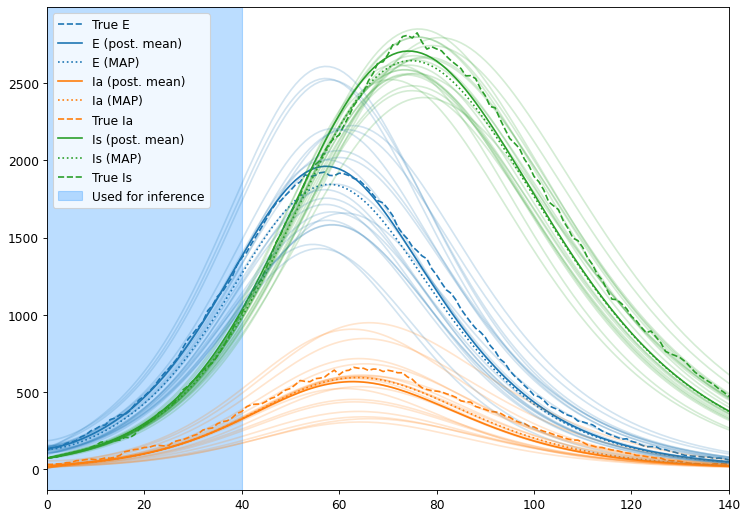

In [11]:
post_mean = pyross.utils.posterior_mean(samples)
estimator.set_params(post_mean['map_params_dict'])
estimator.set_det_model(post_mean['map_params_dict'])
x_pm = estimator.integrate(post_mean['map_x0'], N_start-1, Tf, Nf-N_start) * N
estimator.set_params(params['map_params_dict'])
estimator.set_det_model(params['map_params_dict'])
x_map = estimator.integrate(params['map_x0'], N_start-1, Tf, Nf-N_start) * N
x = np.load('latent_SEIR_traj.npy').astype('float')[N_start:]
fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x[:,M], label='True E', c="C0", linestyle='dashed')
plt.plot(x_pm[:, M], label='E (post. mean)', c="C0")
plt.plot(x_map[:, M], label='E (MAP)', c="C0", linestyle='dotted')
plt.plot(x_pm[:, 2*M], label='Ia (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Ia (MAP)', c="C1", linestyle='dotted')
plt.plot(x[:,2*M], label='True Ia', c="C1", linestyle='dashed')
plt.plot(np.sum(x_pm[:, 3*M:], axis=1), label='Is (post. mean)', c="C2")
plt.plot(np.sum(x_map[:, 3*M:], axis=1), label='Is (MAP)', c="C2", linestyle='dotted')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is', c="C2", linestyle='dashed')
for sample in pyross.utils.resample(samples, 20):
    estimator.set_params(sample['map_params_dict'])
    estimator.set_det_model(sample['map_params_dict'])
    x_det = estimator.integrate(sample['map_x0'], N_start-1, Tf, Nf-N_start) * N
    plt.plot(x_det[:, M], c="C0", alpha=0.2)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.2)
    plt.plot(np.sum(x_det[:, 3*M:], axis=1), c="C2", alpha=0.2)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()

## 3) Compute the model evidence for the SIR model
We take the same data points as in 2).

In [12]:
estimator2 = pyross.inference.SIR(parameters, M, fi, int(N), steps)

eps = 1e-3

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]

fltr2=np.kron([[1, 1, 1], [0, 0, 1]], np.identity(M))
obs2=np.einsum('ij,kj->ki', fltr, x) 
x02=x[0]

param_priors2 = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 5]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 5]
    }
}
init_fltr2 = np.repeat([False, True, False], M)
init_priors2 = {
    'independent':{
        'fltr': init_fltr2, 
        'mean': [*Ia0_g], 
        'std': [*Ia_std], 
        'bounds': [*bounds_for_Ia]
    }
}

start_time = time.time()
sampler2 = estimator2.nested_sampling_latent_inference(obs2, fltr2, Tf_inference, contactMatrix, param_priors2, init_priors2,  
                                                       tangent=True, verbose=True, nlive=150, nprocesses=2) 
end_time = time.time()
print(end_time - start_time)

result2, samples2 = estimator2.nested_sampling_latent_inference_process_result(sampler2, obs2, fltr2, param_priors2, init_priors2)

1944it [04:49,  6.71it/s, +150 | bound: 23 | nc: 1 | ncall: 11045 | eff(%): 18.959 | loglstar:   -inf < 1230.615 <    inf | logz: 1219.567 +/-  2.072 | dlogz:  0.001 >  0.159]


291.55741453170776


In [13]:
print("Model log-evidence for SIR (computed by nested sampling): ", result2.logz[-1])

Model log-evidence for SIR (computed by nested sampling):  1219.5665796801416


In [14]:
ftol = 1e-9 # the relative tol in (-logp)  

params2 = estimator2.latent_infer_parameters(obs2, fltr2, Tf_inference, contactMatrix, param_priors2, init_priors2,
                                             tangent=True, global_max_iter=200, local_max_iter=1000, global_atol=1.0, 
                                             cma_population=50, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 5 (seed=90173287, Mon Jul 20 18:35:18 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -1.128696322064629e+03 1.0e+00 1.08e+00  2e-04  1e-01 0:01.2
    2    100 -1.147348430498107e+03 1.3e+00 9.13e-01  2e-04  9e-02 0:02.3
    3    150 -1.199348616241926e+03 1.5e+00 8.87e-01  2e-04  8e-02 0:03.1
    7    350 -1.244752316326262e+03 2.6e+00 8.55e-01  2e-04  7e-02 0:07.1
   10    500 -1.248948630469664e+03 3.2e+00 8.63e-01  2e-04  9e-02 0:11.7
   15    750 -1.244187280184902e+03 8.6e+00 5.61e-01  1e-04  5e-02 0:17.6
   21   1050 -1.250458957962878e+03 8.5e+01 4.66e-01  9e-05  3e-02 0:23.8
   29   1450 -1.250807509179908e+03 2.6e+02 2.85e-01  3e-05  6e-03 0:31.3
   31   1550 -1.250819210450202e+03 3.0e+02 2.68e-01  3e-05  4e-03 0:33.4
Optimal value (global minimisation):  -1250.8192104502025
Starting local minimisation...
Optimal value (local minimisation):  -1250.824

In [15]:
# The finite difference computation of the Hessian turns out to be a major problem here. Slightly varying the eps parameters
# gives substantially different results, which means that these results cannot be trusted.
# log_evidence = estimator2.log_G_evidence_latent(param_keys2, init_fltr2, params2, guess2, stds2, obs2, fltr2, Tf_inference, Nf_inference, 
#                                                 contactMatrix, tangent=True, eps=1e-2*params2)

In [16]:
# print("Model log-evidence for SIR (computed by Laplace approximation): ", log_evidence) 

### 3.1) Plot samples of the posterior, posterior mean and MAP estimate

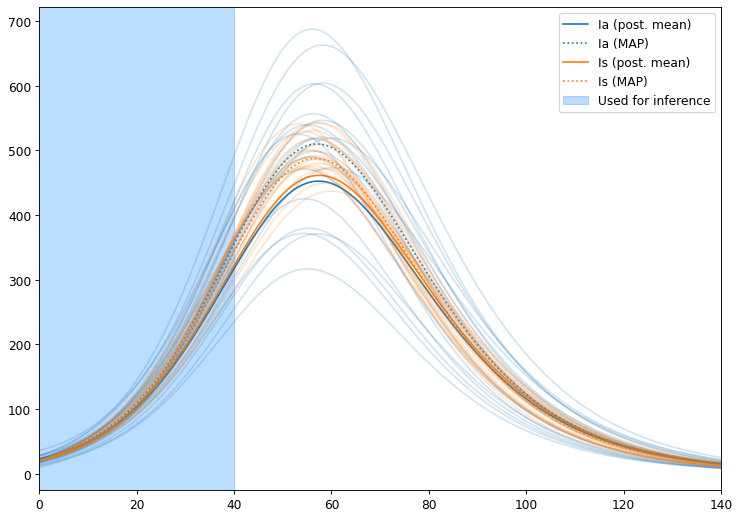

In [17]:
post_mean = pyross.utils.posterior_mean(samples2)
estimator2.set_params(post_mean['map_params_dict'])
estimator2.set_det_model(post_mean['map_params_dict'])
x_pm = estimator2.integrate(post_mean['map_x0'], N_start-1, Tf, Nf-N_start) * N
estimator2.set_params(params2['map_params_dict'])
estimator2.set_det_model(params2['map_params_dict'])
x_map = estimator2.integrate(params2['map_x0'], N_start-1, Tf, Nf-N_start) * N

fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x_pm[:, M], label='Ia (post. mean)', c="C0")
plt.plot(x_map[:, M], label='Ia (MAP)', c="C0", linestyle='dotted')
plt.plot(x_pm[:, 2*M], label='Is (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Is (MAP)', c="C1", linestyle='dotted')
for sample in pyross.utils.resample(samples2, 20):
    estimator2.set_params(sample['map_params_dict'])
    estimator2.set_det_model(sample['map_params_dict'])
    x_det = estimator2.integrate(sample['map_x0'], N_start-1, Tf, Nf-N_start) * N
    plt.plot(x_det[:, M], c="C0", alpha=0.2)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.2)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()